In [1]:
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter

from utilities.game_utilities import filter_by_team_and_season, generate_shot_map_matrix, get_goals_per_game
from utilities.math_utilities import subtract_and_align_matrices

sns.set()

In [2]:
plays_df = pd.read_csv("./data/extracted/shot_goal_20161012_20210707.csv")

In [4]:
season = 20202021
team = 'Tampa Bay Lightning'
bin_size = 1

team_df = filter_by_team_and_season(plays_df, team, season)

global_matrix = generate_shot_map_matrix(plays_df, bin_size=bin_size)
global_goals_per_game = get_goals_per_game(plays_df, season_filter=season)
team_matrix = generate_shot_map_matrix(team_df, bin_size=bin_size)
team_goals_per_game = get_goals_per_game(team_df, team_filter=team, season_filter=season)

print(f'Shots per game: {team_matrix.sum().sum()}')
print(
    f'Shots differential per game compared to NHL average: {team_matrix.sum().sum() - global_matrix.sum().sum()} ({(team_matrix.sum().sum() - global_matrix.sum().sum()) / global_matrix.sum().sum() * 100}%)')
print(f'Goals scored per game: {team_goals_per_game}')
print(
    f'Goals scored differential per game compared to NHL average: {team_goals_per_game - global_goals_per_game} ({(team_goals_per_game - global_goals_per_game) / global_goals_per_game * 100}%)')

difference_matrix = subtract_and_align_matrices(team_matrix, global_matrix, 0.0)
# Sort by decreasing distance from center ice so center ice appears at the bottom of the graph
difference_matrix.sort_index(ascending=False, kind='mergesort', inplace=True)

Shots per game: 29.49367088607595
Shots differential per game compared to NHL average: -0.485208209217582 (-1.6185001703207649%)
Goals scored per game: 3.2278481012658227
Goals scored differential per game compared to NHL average: 0.33944547544525383 (11.752013808975834%)


<AxesSubplot:xlabel='Distance from center of rink (ft)', ylabel='Distance from center ice to goal (ft)'>

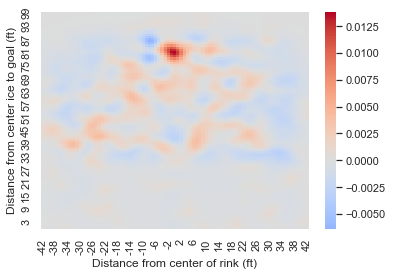

In [5]:
df3_smooth = gaussian_filter(difference_matrix, sigma=2, order=0)
difference_matrix_smooth = pd.DataFrame(data=df3_smooth, index=difference_matrix.index,
                                        columns=difference_matrix.columns)
sns.heatmap(difference_matrix_smooth, cmap="coolwarm", center=0)

In [79]:
import plotly.express as px
import plotly.graph_objects as go
df = px.data.tips()

#fig = px.density_heatmap(df)
fig = go.Figure()
fig.add_trace(go.Heatmap(z=difference_matrix_smooth))



# Update plot sizing
fig.update_layout(
    width=467,
    height=550,
    autosize=False,
    margin=dict(t=100, b=0, l=0, r=0),
)

# Add dropdowns
button_layer_1_height = 1.25

fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=["Saison", "20191"],
                    label="20191",
                    method="restyle"
                ),
                dict(
                    args=["Saison", "20192"],
                    label="20192",
                    method="restyle"
                ),
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
        dict(
            buttons=list([
                dict(
                    args=[{"contours.showlines": False, "type": "contour"}],
                    label="CM",
                    method="restyle"
                ),
                dict(
                    args=[{"contours.showlines": True, "type": "contour"}],
                    label="B",
                    method="restyle"
                ),
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.58,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
    ]
)

fig.add_layout_image(
        dict(
            source="../figures/nhl_rink_offensive.png",
            xref="x",
            yref="y",
            x=0,
            y=99,
            sizex=84,
            sizey=99,
            sizing="stretch",
            opacity=0.5,
            layer="above")
)

fig.update_layout(template="plotly_white")

fig.show()

In [3]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [4]:
def compute_heatmap_res(season, team):
    bin_size = 1

    team_df = filter_by_team_and_season(plays_df, team, season)

    global_matrix = generate_shot_map_matrix(plays_df, bin_size=bin_size)
    global_goals_per_game = get_goals_per_game(plays_df, season_filter=season)
    team_matrix = generate_shot_map_matrix(team_df, bin_size=bin_size)
    team_goals_per_game = get_goals_per_game(team_df, team_filter=team, season_filter=season)

    difference_matrix = subtract_and_align_matrices(team_matrix, global_matrix, 0.0)
    # Sort by decreasing distance from center ice so center ice appears at the bottom of the graph
    difference_matrix.sort_index(ascending=False, kind='mergesort', inplace=True)

    ########
    df3_smooth = gaussian_filter(difference_matrix, sigma=2, order=0)
    difference_matrix_smooth = pd.DataFrame(data=df3_smooth, index=difference_matrix.index,
                                    columns=difference_matrix.columns)
    
    return difference_matrix_smooth

In [5]:
team_list = plays_df['team'].unique()
season_list = plays_df['season'].unique()

team_season_dict = {}

for current_season in season_list:
        for current_team in team_list:
                team_season_dict[str(current_team)+str(current_season)] = compute_heatmap_res(current_season, current_team)

In [6]:
image = Image.open("../figures/nhl_rink_offensive.png")

def display_fig(season, team):

        difference_matrix_smooth = team_season_dict[str(team)+str(season)]


        fig, ax = plt.subplots()
        im = ax.imshow(difference_matrix_smooth)

        
        #img = mpimg.imread('../ift6758/1hockey.jpg')
        ax.imshow(image, zorder=0,  extent=[0, 80, 0, 95],  alpha = 0.5)



        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")



        fig.tight_layout()

        plt.show()

In [7]:
from IPython.display import display
from IPython.display import clear_output

import ipywidgets as widgets
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

season_list = plays_df['season'].unique()
season_list_out = widgets.Output()
season_selection = season_list[0]


###############################
out = widgets.Output()
###############################


team_list = plays_df['team'].unique()
team_list_out = widgets.Output()
team_selection = team_list[0]

################################

seasons_widget = widgets.Select(
    options=season_list,
    value=season_list[0],
    # rows=10,
    description='Season:',
    disabled=False
)

#display(seasons_widget, season_list_out)

def on_value_change(change):
    with out:
        #print(change['new'])
        season_selection = change['new']
        clear_output(wait=True)
        display_fig(season_selection, team_selection)



seasons_widget.observe(on_value_change, names='value')

##########


team_widget = widgets.Select(
    options=team_list,
    value=team_list[0],
    # rows=10,
    description='Team:',
    disabled=False
)

#display(team_widget, team_list_out)

def on_value_change_team(change):
    with out:
        #print(change['new'])
        team_selection = change['new']
        clear_output(wait=True)
        display_fig(season_selection, team_selection)



team_widget.observe(on_value_change_team, names='value')

widgets.HBox([widgets.VBox([seasons_widget, team_widget]), out])

